# Sentinel‑2 Kiln Detection – Baseline Notebook
Ein modular aufgebautes Notebook zur Segmentierung kleiner Ziegelöfen in Sentinel‑2-Daten (Beispielland: Indien).

## 1 · Installation & Imports

In [3]:
# ─── 1 · Imports ──────────────────────────────────────────────────────────────
import os, glob, random, zipfile, getpass, numpy as np, torch, rasterio, matplotlib.pyplot as plt
import torchvision.transforms as T
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2 · Konstanten & Datenpfade

In [ ]:
# ─── 2 · Konstanten & Datenpfade – PALMA-ready ───────────────────────────────
USER          = getpass.getuser()                     # z.B. 'tstraus2'
SCRATCH       = os.environ.get("SLURM_TMPDIR", f"/scratch/tmp/{USER}")
ZIP_PATH      = f"{SCRATCH}/Brick_Data_Train.zip"     # hierher hast du die ZIP kopiert
DATA_ROOT     = os.path.join(SCRATCH, "Brick_Data_Train")

# Datensatz ggf. entpacken
if not os.path.isdir(DATA_ROOT):
    if os.path.isfile(ZIP_PATH):
        print(f"Entpacke {ZIP_PATH} nach {DATA_ROOT} …")
        with zipfile.ZipFile(ZIP_PATH, "r") as zf:
            zf.extractall(SCRATCH)
    else:
        raise FileNotFoundError(f"{ZIP_PATH} nicht gefunden!")

IMG_DIR      = os.path.join(DATA_ROOT, "Image")
MASK_DIR     = os.path.join(DATA_ROOT, "Mask")        # Ordner-Name prüfen
PATCH_SIZE   = 256
BATCH_SIZE   = 8
LR           = 1e-3
EPOCHS       = 20
NUM_CLASSES  = 10
pl.seed_everything(42, workers=True)


## 3 · Hilfsfunktionen

In [6]:
# ─── 3 · Hilfsfunktion ───────────────────────────────────────────────────────
def read_s2_image(path: str) -> torch.Tensor:
    """Liest Sentinel-2 GeoTIFF und skaliert DN auf [0,1]."""
    with rasterio.open(path) as src:
        img = src.read(out_dtype=np.float32)
    return torch.from_numpy(img / 10000.0)



### 3.1 · Dataset-Klasse

In [19]:
# ─── 4 · Dataset-Klasse ──────────────────────────────────────────────────────
class SentinelKilnDataset(Dataset):
    """Bild-/Masken-Dataset mit Zufalls-Patch und 10-Klassen-Label."""
    def __init__(self, img_dir, mask_dir, patch_size=256, transform=None):
        self.img_paths  = sorted(glob.glob(os.path.join(img_dir, "*.tif")))
        assert self.img_paths, f"Keine Bilder in {img_dir}"
        self.mask_dir   = mask_dir
        self.patch_size = patch_size
        self.norm       = transform or T.Normalize(mean=[0.3]*4, std=[0.2]*4)

    def __len__(self): return len(self.img_paths)

    def __getitem__(self, idx):
        # Bild
        img_path = self.img_paths[idx]
        img      = read_s2_image(img_path)[:4]

        # Maske (0…10) → -1…9
        mask_path = os.path.join(self.mask_dir, os.path.basename(img_path))
        with rasterio.open(mask_path) as src:
            mask = torch.from_numpy(src.read(1)).long() - 1   # -1 BG, 0…9 Klassen

        # Zufälliger Patch
        _, H, W = img.shape
        top  = random.randint(0, H - self.patch_size)
        left = random.randint(0, W - self.patch_size)
        img  = img[:,  top:top+self.patch_size, left:left+self.patch_size]
        mask = mask[   top:top+self.patch_size, left:left+self.patch_size]

        img = self.norm(img)
        return img, mask


### 3.2 · Daten-Vorschau

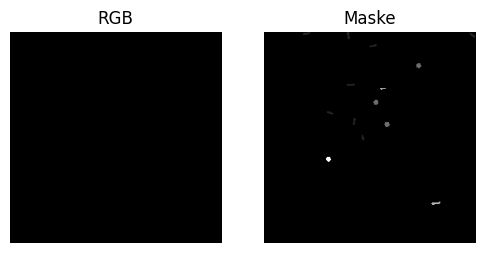

In [20]:
# ─── 5 · Daten-Vorschau ──────────────────────────────────────────────────────
ds_preview = SentinelKilnDataset(IMG_DIR, MASK_DIR, PATCH_SIZE)
x, y = ds_preview[0]
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.title("RGB"); plt.imshow((x[[2,1,0]]*2.5).clamp(0,1).permute(1,2,0)); plt.axis("off")
plt.subplot(1,2,2); plt.title("Maske"); plt.imshow(y, cmap="tab10"); plt.axis("off")
plt.show()


### 3.3 · DataLoader

In [21]:
# ─── 6 · DataLoader ──────────────────────────────────────────────────────────
def build_loaders():
    ds = SentinelKilnDataset(IMG_DIR, MASK_DIR, PATCH_SIZE)
    val_len = max(1, int(0.1 * len(ds)))
    train_ds, val_ds = random_split(ds, [len(ds) - val_len, val_len])
    dl_kwargs = dict(batch_size=BATCH_SIZE,
                     num_workers=os.cpu_count(),
                     pin_memory=torch.cuda.is_available())
    return (DataLoader(train_ds, shuffle=True,  **dl_kwargs),
            DataLoader(val_ds,   shuffle=False, **dl_kwargs))

train_loader, val_loader = build_loaders()
print(len(train_loader), "Train-Batches |", len(val_loader), "Val-Batches")


(841, 94)

## 4 · Modell – minimaler UNet

In [22]:
# ─── 7 · Modell – UNet (10 Klassen) ──────────────────────────────────────────
class DoubleConv(nn.Module):
    def __init__(self, inc, outc):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(inc, outc, 3, padding=1, bias=False),
            nn.BatchNorm2d(outc), nn.ReLU(inplace=True),
            nn.Conv2d(outc, outc, 3, padding=1, bias=False),
            nn.BatchNorm2d(outc), nn.ReLU(inplace=True),
        )
    def forward(self,x): return self.net(x)

class UNet(pl.LightningModule):
    def __init__(self, lr=1e-3, num_classes=NUM_CLASSES):
        super().__init__()
        self.save_hyperparameters()
        self.enc1 = DoubleConv(4,64); self.enc2 = DoubleConv(64,128)
        self.pool = nn.MaxPool2d(2)
        self.up   = nn.ConvTranspose2d(128,64,2,2)
        self.dec1 = DoubleConv(128,64)
        self.out  = nn.Conv2d(64, num_classes, 1)
        self.loss = nn.CrossEntropyLoss(ignore_index=-1)

    def forward(self,x):
        c1 = self.enc1(x); x = self.pool(c1); x = self.enc2(x)
        x  = self.up(x);  x = torch.cat([x,c1],1); x = self.dec1(x)
        return self.out(x)

    def _step(self,b):
        x,y = b; logit = self(x); return self.loss(logit,y)

    def training_step(self,b,idx):
        l = self._step(b); self.log("train_loss",l,prog_bar=True); return l
    def validation_step(self,b,idx):
        l = self._step(b); self.log("val_loss",l,prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


## 5 · Training

In [ ]:
# ─── 8 · Training ────────────────────────────────────────────────────────────
model  = UNet(lr=LR)
ckpt   = ModelCheckpoint(monitor="val_loss", save_top_k=1)
lrmon  = LearningRateMonitor(logging_interval="epoch")
trainer = pl.Trainer(accelerator="auto", devices=1,
                     precision="16-mixed", max_epochs=EPOCHS,
                     callbacks=[ckpt, lrmon], log_every_n_steps=10)

trainer.fit(model, train_loader, val_loader)


## 6 · Evaluation

In [ ]:
# ─── 9 · Evaluation ──────────────────────────────────────────────────────────
import torchmetrics

metric = torchmetrics.classification.MulticlassJaccardIndex(
    num_classes=NUM_CLASSES, ignore_index=-1, average='none'
).to(model.device)

model.eval(); metric.reset()
with torch.no_grad():
    for xb, yb in val_loader:
        preds = torch.argmax(model(xb.to(model.device)), 1)
        metric.update(preds.cpu(), yb)

ious  = metric.compute()
valid = ~torch.isnan(ious)
print("IoU pro Klasse:", ious)
print("Mean IoU:", ious[valid].mean().item() if valid.any() else 0.0)


## 7 · Inference & Visualisierung

In [ ]:
# ─── 10 · Inference & Visualisierung ─────────────────────────────────────────
def infer_full_tif(path_img, norm_fn, window=PATCH_SIZE):
    img = read_s2_image(path_img)[:4]
    img = norm_fn(img)                         # Szenen-Normierung
    _, H, W = img.shape
    full_logits = torch.zeros(NUM_CLASSES, H, W)

    model.eval()
    with torch.no_grad():
        for top in range(0, H-window+1, window):
            for left in range(0, W-window+1, window):
                patch = img[:, top:top+window, left:left+window].unsqueeze(0).to(model.device)
                full_logits[:, top:top+window, left:left+window] = model(patch).cpu().squeeze(0)

    pred = full_logits.argmax(0)               # [H,W] Klassenindex
    plt.figure(figsize=(12,4))
    plt.subplot(121); plt.title("RGB")
    plt.imshow((img[[2,1,0]]*2.5).clamp(0,1).permute(1,2,0)); plt.axis("off")
    plt.subplot(122); plt.title("Prediction")
    plt.imshow(pred, cmap="tab10"); plt.axis("off")
    plt.show()


## 8 · Gewichts‑Export

In [ ]:
torch.save(model.state_dict(), 'unet_kiln_sentinel2.pt')
print('Model gespeichert.')